### Домашнее задание TSML-9 №2

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
1. Приблизьте оба варианта моделями из класса MA.
1. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [470]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [471]:
def test_stationarity(name,timeseries):
    print(f'Results of Dickey-Fuller Test for {name}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dftest[1]#p-value

In [472]:
def tsplot(name, y, lags=None, figsize=(14, 8), style='bmh'):
    pval=test_stationarity(name,y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(f'{name}')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return pval

In [473]:
series_femalebirths = pd.read_csv("Series\daily-total-female-births-in-cal.csv")['Count'].dropna()
series_airline = pd.read_csv("Series\international-airline-passengers.csv")['Count'].dropna()
series_temperature = pd.read_csv("Series\mean-monthly-air-temperature-deg.csv")['Deg'].dropna()
#series_robberies = pd.read_csv("Series\monthly-boston-armed-robberies-j.csv")['Count'].dropna()
#series_sales= pd.read_csv("Series\monthly-sales-of-company-x-jan-6.csv")['Count'].dropna()
#series_dowjones = pd.read_csv("Series\weekly-closings-of-the-dowjones-.csv")['Close'].dropna()
series_femalebirths.head()

0    35
1    32
2    30
3    31
4    44
Name: Count, dtype: int64

уберем изменение дисперсии при помощи преобразования Бокса-Кокса


In [474]:
#series_femalebirths = pd.Series(boxcox(series_femalebirths, 0))
#series_airline = pd.Series(boxcox(series_airline, 0))
#series_temperature = pd.Series(boxcox(series_temperature, 0))
#series_robberies = pd.Series(boxcox(series_robberies, 0))
#series_sales = pd.Series(boxcox(series_sales, 0))
#series_dowjones = pd.Series(boxcox(series_dowjones, 0))


In [475]:
lst_ser={'series_femalebirths':series_femalebirths
,'series_airline':series_airline
#,'series_temperature':series_temperature 
#,'series_robberies':series_robberies,
#'series_sales':series_sales,
#'series_dowjones':series_dowjones,
#'series_femalebirths':series_femalebirths
}

In [476]:
for k,ser in lst_ser.items():
    print(ser.head())
    #print(ser.info())

0    35
1    32
2    30
3    31
4    44
Name: Count, dtype: int64
0    112
1    118
2    132
3    129
4    121
Name: Count, dtype: int64


Results of Dickey-Fuller Test for series_femalebirths:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64
Гипотеза H0 о нестационарности series_femalebirths отвергается, так как P-value== 5.24E-05 < 5%
Results of Dickey-Fuller Test for series_airline:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Гипотеза H0 о нестационарности series_airline принимается, так как P-value== 9.92E-01 < 5%


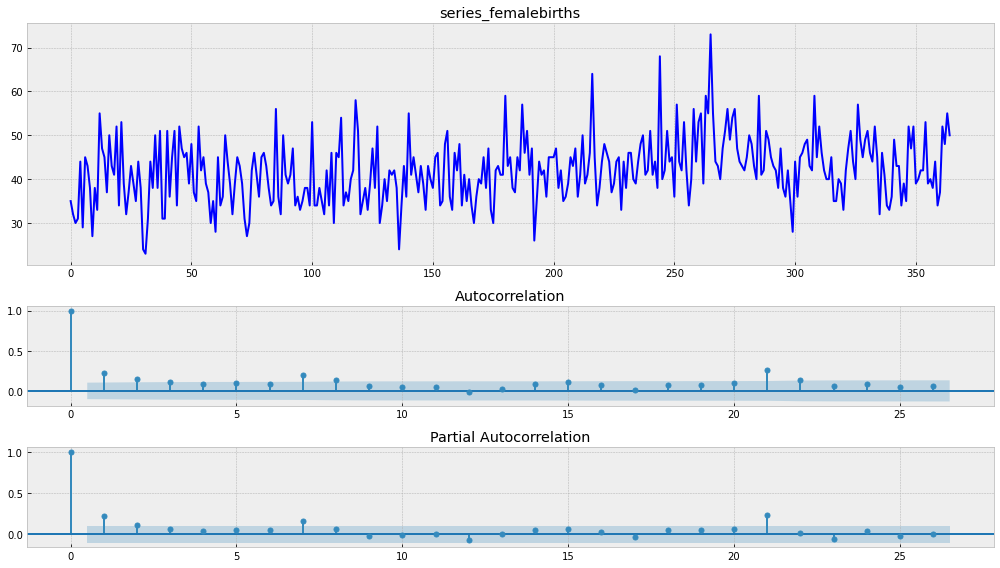

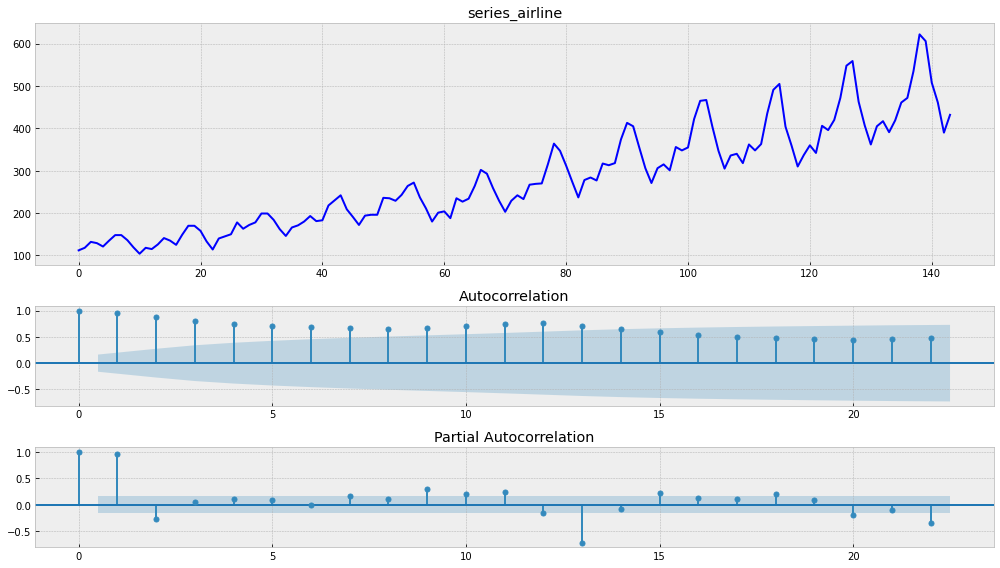

In [477]:
dct_ln={}
for k,ser in lst_ser.items():
    #ser_ln=np.log(ser)
    loc_p_v=tsplot(k,ser)
    if(loc_p_v<0.05):
        dct_ln[k]=ser
        print(f'Гипотеза H0 о нестационарности {k} отвергается, так как P-value=={loc_p_v : .2E} < 5%')
    else:
        print(f'Гипотеза H0 о нестационарности {k} принимается, так как P-value=={loc_p_v : .2E} < 5%')


# Скользящее среднее

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо просто предсказания вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

В данном случае $\hat{y}_{t}$ называется скользящей средней

In [478]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [479]:
#series_femalebirths,series_airline
ser_st = moving_average(series_femalebirths, 7)
ser_nst = moving_average(series_airline, 7)

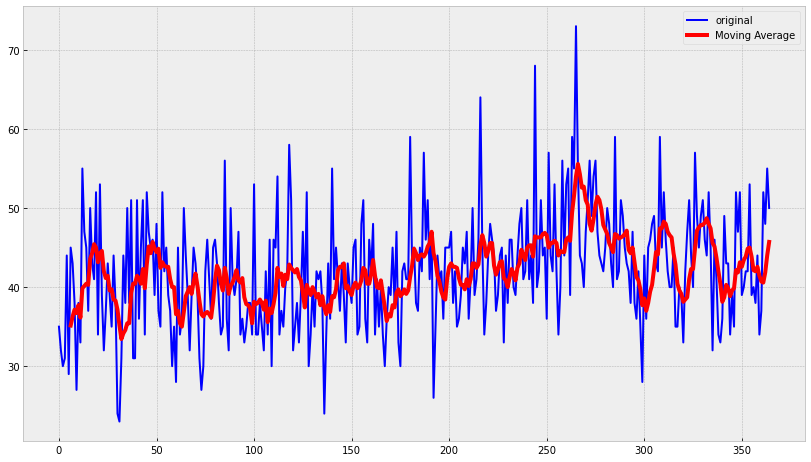

In [480]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_femalebirths, color='blue',label='original')
    plt.plot(ser_st, color='red', linewidth='4', label='Moving Average')
    plt.legend()

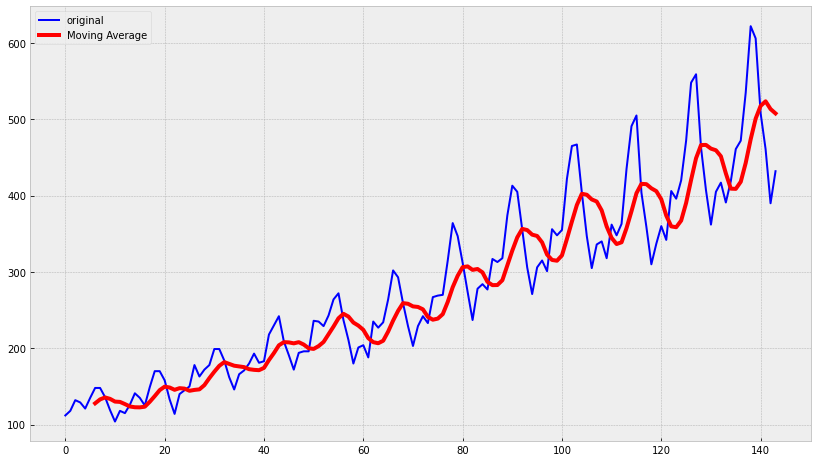

In [481]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_airline, color='blue',label='original')
    plt.plot(ser_nst, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Функция, которая предсказывает 50 следующих измерений.

In [482]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

In [483]:
series_pred_st = predict(series_femalebirths, 7, 50)
series_pred_nst = predict(series_airline, 7, 50)


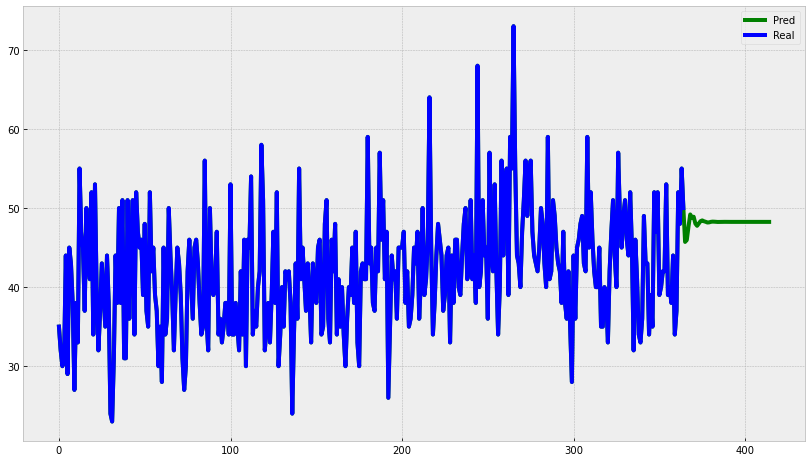

In [484]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred_st, color='green', linewidth='4', label='Pred')
    plt.plot(series_femalebirths, color='blue', linewidth='4', label='Real')
    plt.legend()

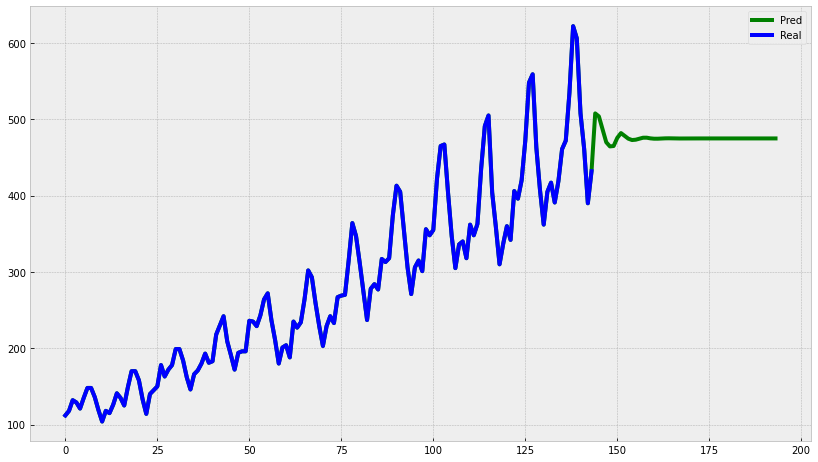

In [485]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred_nst, color='green', linewidth='4', label='Pred')
    plt.plot(series_airline, color='blue', linewidth='4', label='Real')
    plt.legend()

Модификацией обычной скользящей средней является взвешенная скользящая средняя.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

$\displaystyle\sum^{k}_{n=1} {\omega_n} = 1$

Обычно чем ближе измерение к прогнозируемому - тем больше его вес

In [486]:
def weighted_ma(series, n, weights1, weights2, weights3, weights4, weights5, weights6, weights7):
    weights=[weights1, weights2, weights3, weights4, weights5, weights6, weights7]
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    wma[:6]=series[:n-1]
    return wma

In [487]:
def weighted_moving_average(series, n, weights):

    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    
    return wma

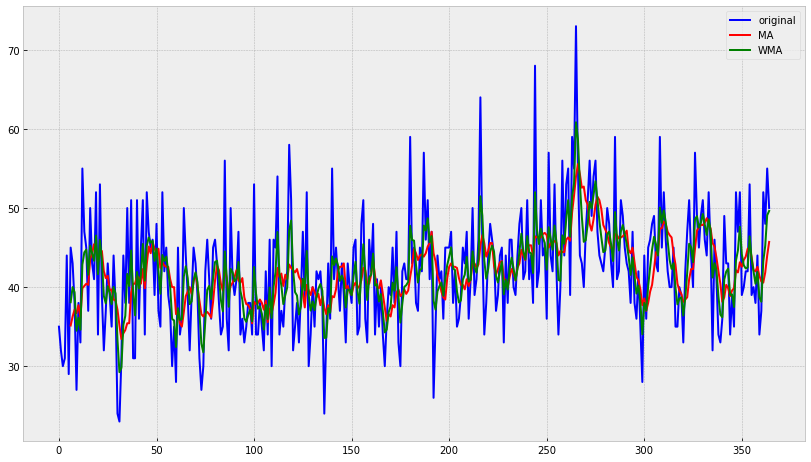

In [488]:
wma = weighted_moving_average(series_femalebirths, 7, [1,1,2,3,5,8,13])
ma = moving_average(series_femalebirths, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_femalebirths, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

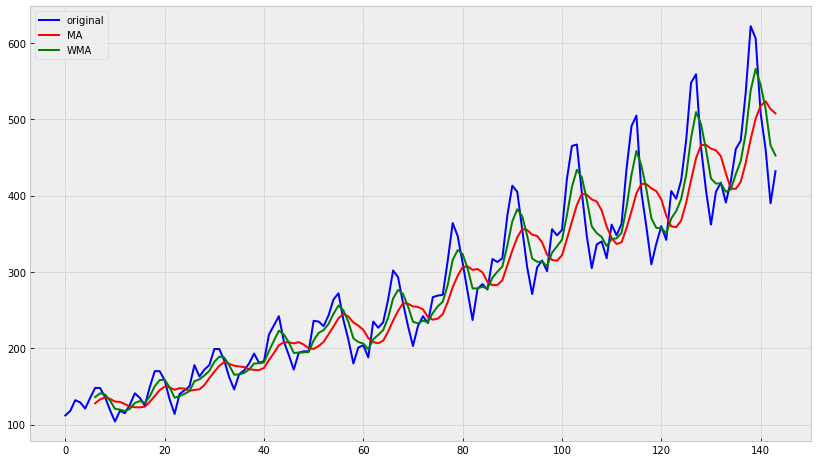

In [489]:
wma = weighted_moving_average(series_airline, 7, [1,1,2,3,5,8,13])
ma = moving_average(series_airline, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_airline, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

In [490]:
series_st = series_femalebirths[:60]
series_nst = series_airline[:60]

wma_fib_st = weighted_moving_average(series_st, 7, [1,1,2,3,5,8,13])
wma_seq_st = weighted_moving_average(series_st, 7, [1,2,3,4,5,6,7])
wma_pow_st = weighted_moving_average(series_st, 7, [1,2,4,8,16,32,64])

wma_fib_nst = weighted_moving_average(series_nst, 7, [1,1,2,3,5,8,13])
wma_seq_nst = weighted_moving_average(series_nst, 7, [1,2,3,4,5,6,7])
wma_pow_nst = weighted_moving_average(series_nst, 7, [1,2,4,8,16,32,64])

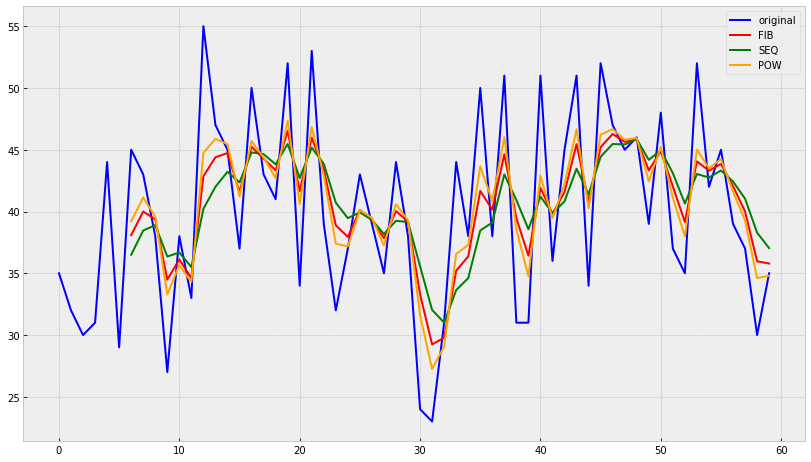

In [491]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_st, color='blue',label='original')
    
    plt.plot(wma_fib_st, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq_st, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow_st, color='orange', linewidth='2', label='POW')
    plt.legend()

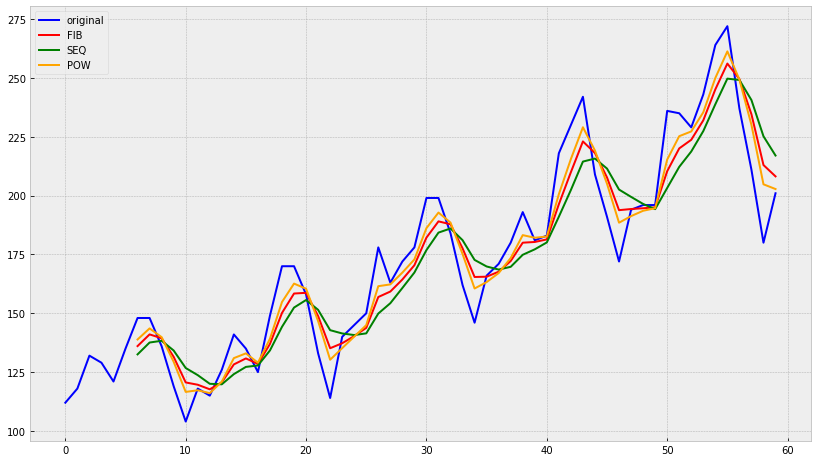

In [492]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    
    plt.plot(wma_fib_nst, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq_nst, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow_nst, color='orange', linewidth='2', label='POW')
    plt.legend()

# Экспоненциальное сглаживание

Продолжаем развивать идею с историей. Мы хотим учитывать на самом деле учитывать не какой-то фиксированный набор измерений. В идеале - мы хотим учитывать всю историю измерений, накопившуюся к текущему моменту. Просто, как и в случае WMA, чем дальше измерение - тем меньше вклад. Для этого используется экспоненциальное скользящее среднее:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

В нем предсказанное значение - это взвешеное срденее между последним наблюдением и предыдущей историей. Легко заметить, что формула рекурсивна. Параметр $\alpha$ называется сглаживающим фактором. Он определяет, как сильно мы будем опираться на историю (чем меньше - тем больше). Чем меньше $\alpha$, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд. 

In [493]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [494]:
ema_st = exponential_moving_average(series_femalebirths, 0.2)
ema_nst = exponential_moving_average(series_airline, 0.2)

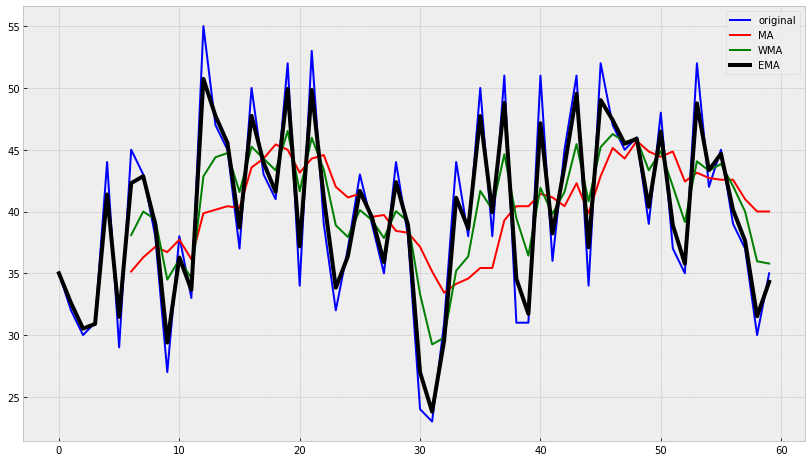

In [495]:
ema_st = exponential_moving_average(series_femalebirths[:60], 0.8)
wma_st = weighted_moving_average(series_femalebirths[:60], 7, [1,1,2,3,5,8,13])
ma_st= moving_average(series_femalebirths[:60], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_femalebirths[:60], color='blue',label='original')
    plt.plot( ma_st, color='red', linewidth='2', label='MA')
    plt.plot(wma_st, color='green', linewidth='2', label='WMA')
    plt.plot(ema_st, color='black', linewidth='4', label='EMA')
    plt.legend()

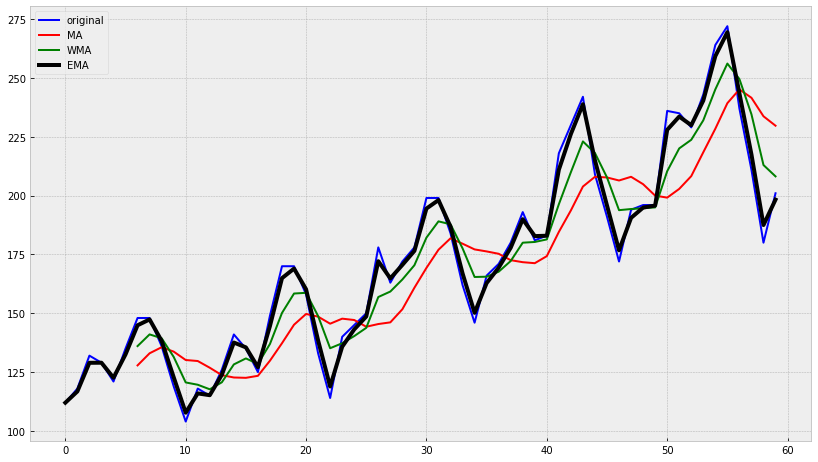

In [496]:
ema_nst = exponential_moving_average(series_airline[:60], 0.8)
wma_nst = weighted_moving_average(series_airline[:60], 7, [1,1,2,3,5,8,13])
ma_nst= moving_average(series_airline[:60], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_airline[:60], color='blue',label='original')
    plt.plot( ma_nst, color='red', linewidth='2', label='MA')
    plt.plot(wma_nst, color='green', linewidth='2', label='WMA')
    plt.plot(ema_nst, color='black', linewidth='4', label='EMA')
    plt.legend()

# Двойное экспоненциальное сглаживание
$$\hat{y}_t=l_t + s_t$$
$$\hat{y}_t=\alpha y_t + (1-\alpha)\hat{y}_{t-1}$$
$$\hat{l}_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$$

До сих пор мы рассматривали ряд - как единую составляющую. Но на самом деле, ряд $y_t$ можно представить в виде суммы $l_t$ (уровня) и $s_t$ (тренда). По сути - тренд - это основное направление движения ряда, а уровень - колебание вокруг этого тренда.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

In [497]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [498]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

train, test, val = series_airline[:60].reset_index(drop=True), series_airline[60:120].reset_index(drop=True), series_airline[120:].reset_index(drop=True)

In [499]:
def mse_wma(X):
    fib1, fib2, fib3, fib4, fib5, fib6, fib7 = X
    predictions = weighted_ma(train, 7, 
                                          fib1, fib2, fib3, fib4, fib5, fib6, fib7)  
    # double_ema(train, alpha, beta)
    #predictions = result[-len(test):]
    error = mean_squared_error(predictions, train)
    return error


In [500]:
mse_wma([1,1,2,3,5,8,13])

161.7098561371288

In [501]:
def mse_2ema(X):
    alpha, beta = X
    predictions = double_ema(train, alpha, beta)
    #predictions = result[-len(test):]
    error = mean_squared_error(predictions, train)
    return error

In [502]:
def plot_X_ma(param_list, ser_pred, ser_to_plot):

    if len(param_list) < 7:
        alpha, beta = param_list
        tema = double_ema(ser_pred, alpha, beta)
    else:
        fib1, fib2, fib3, fib4, fib5, fib6, fib7 = param_list
        tema = weighted_ma(ser_pred, 7, fib1, fib2,
                           fib3, fib4, fib5, fib6, fib7)

    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue', label='original')
        plt.plot(tema, color='red', linewidth='4', label='DEMA')
        #plt.title("alpha={}, beta={}".format(alpha, beta))
        if len(param_list) < 7:
            plt.title("alpha={}, beta={}".format(alpha, beta))
        else:
            plt.title("fib1={}, fib2={},, fib3={},, fib4={},, fib5={},, fib6={},, fib7={}".format(
                fib1, fib2, fib3, fib4, fib5, fib6, fib7))

        plt.legend()


In [503]:
opt = minimize(mse_2ema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt, beta_opt= opt.x
print(opt)

      fun: 11.383459009837868
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.52766687e-05, 1.42108547e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 16
     njev: 18
   status: 0
  success: True
        x: array([0.97293319, 0.07849387])


In [504]:
print(f'RMSE={mean_squared_error(double_ema(test, alpha_opt, beta_opt), test)}')

RMSE=30.413307267581434


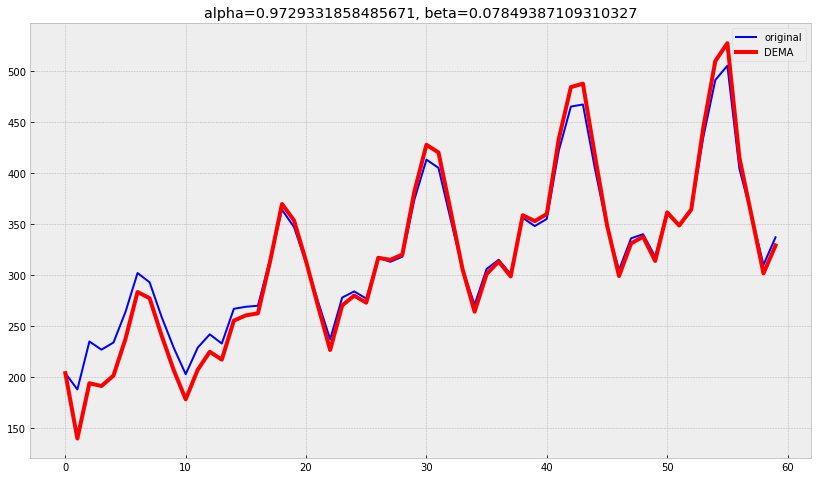

In [505]:
plot_X_ma([alpha_opt, beta_opt], ser_pred=double_ema(test, alpha_opt, beta_opt), ser_to_plot=test)

In [506]:
train, test, val = series_femalebirths[:60].reset_index(drop=True), series_femalebirths[60:120].reset_index(drop=True), series_femalebirths[120:].reset_index(drop=True)

In [507]:
opt = minimize(mse_2ema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt, beta_opt= opt.x
print(opt)

      fun: 0.8952147823707295
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.10862445e-07, 3.04201109e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 18
     njev: 20
   status: 0
  success: True
        x: array([0.95695964, 0.10188262])


In [508]:
print(f'RMSE={mean_squared_error(double_ema(test, alpha_opt, beta_opt), test)}')

RMSE=25.78749380323135


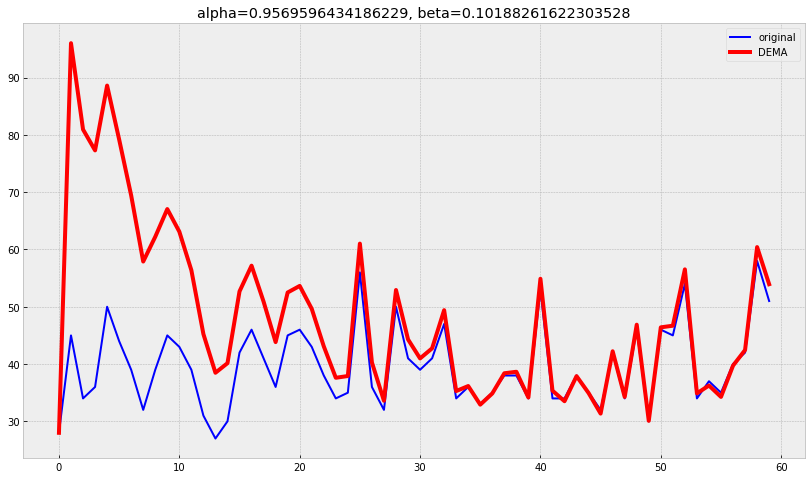

In [509]:
plot_X_ma([alpha_opt, beta_opt], ser_pred=double_ema(test, alpha_opt, beta_opt), ser_to_plot=test)

Посмотрим какие результаты даст взвешенное среднее

In [510]:
train, test, val = series_femalebirths[:60].reset_index(drop=True), series_femalebirths[60:120].reset_index(drop=True), series_femalebirths[120:].reset_index(drop=True)

In [511]:
opt = minimize(mse_wma, x0=[0, 0, 0, 0, 0, 0, 0], method="L-BFGS-B",
               bounds=((0, 1), (0, 1), (1, 2), (2, 3), (3, 5), (5, 8), (8, 13)))
fib1, fib2, fib3, fib4, fib5, fib6, fib7 = opt.x
print(opt)
#


      fun: 14.094762731481485
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.7526932 ,  0.68880475,  1.36021595,  1.17016957,  1.08093428,
        1.66519279, -1.17456328])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([ 0.,  0.,  1.,  2.,  3.,  5., 13.])


In [512]:

print(f'RMSE={mean_squared_error(weighted_ma(test, 7, fib1, fib2, fib3, fib4, fib5, fib6, fib7) , test)}')

RMSE=11.601591435185183


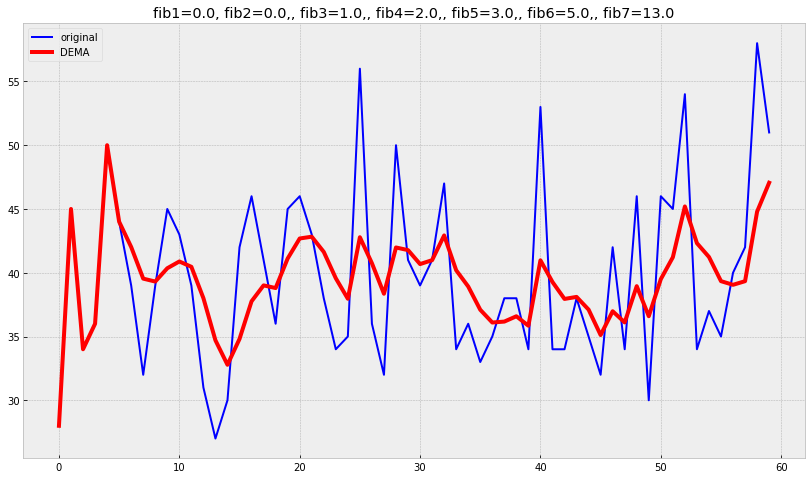

In [513]:
plot_X_ma([fib1, fib2, fib3, fib4, fib5, fib6, fib7], ser_pred=weighted_ma(test, 7, fib1, fib2, fib3, fib4, fib5, fib6, fib7), ser_to_plot=test)

In [467]:
len(train)

60

In [469]:
train.size

60

In [514]:
'''def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series
series_pred = predict(series_airline, 7, 50)'''

In [515]:
'''def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma'''

In [613]:
def weighted_ma(series, n, weights1, weights2, weights3, weights4, weights5, weights6, weights7, n_pred):
    weights = [weights1, weights2, weights3,
               weights4, weights5, weights6, weights7]
               

    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
        

    wma = series.rolling(n).apply(lambda s: (
        s * weights).sum() / weights.sum(), raw=True)
    wma[:6] = series[:n-1]

    new_series = wma[-n:].copy()
    for _ in range(n_pred):
        new_series = new_series.append((new_series.rolling(n).apply(lambda s: (
            s * weights).sum() / weights.sum(), raw=True)[-1:]), ignore_index=True)


    return new_series  


In [637]:
weights = pd.Series([1,1,2,3,5,8,13])
n=7
series=series_airline[:60].copy()

if not isinstance(weights, np.ndarray):
    weights = np.array(weights)
if not isinstance(series, pd.Series):
    series = pd.Series(series)

wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

#wma[:6] = series[:n-1]
wma[:10]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6    136.060606
7    141.030303
8    139.393939
9    131.484848
Name: Count, dtype: float64

In [640]:
new_series = wma[-n:].copy().reset_index(drop=True)
new_series

0    232.000000
1    245.151515
2    256.121212
3    249.545455
4    234.575758
5    213.000000
6    208.181818
Name: Count, dtype: float64

In [641]:
new_series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)[-1:]

6    221.856749
Name: Count, dtype: float64

In [642]:


new_series = wma[-n:].copy().reset_index(drop=True)

for _ in range(1):
    new_series = new_series.append((new_series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)[-1:]), ignore_index=True)

new_series

0    232.000000
1    245.151515
2    256.121212
3    249.545455
4    234.575758
5    213.000000
6    208.181818
7    221.856749
Name: Count, dtype: float64

In [516]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

In [517]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

In [537]:
def initial_trend(series, season_len):
    num_seasons = len(series)//season_len
    ser_trend = pd.Series([1,2])
    for i, s_v in enumerate(series):
        ser_trend[i] = (series[i+season_len]-series[i])/season_len
        num_seasons -= 1
        if num_seasons == 0:
            break

        
    num_seasons = len(series)//season_len
    return sum(ser_trend)/num_seasons


def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:  # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):  # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i % slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha * \
                (val-seasonals[i % slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i % slen] = gamma * \
                (val-smooth) + (1-gamma)*seasonals[i % slen]
            result.append(smooth+trend+seasonals[i % slen])
    return result


In [538]:
initial_trend(series_airline, 12)

1.0069444444444444

In [541]:
def plot_tema(alpha, beta, gamma, ser=series_airline, ser_to_plot=series_airline, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

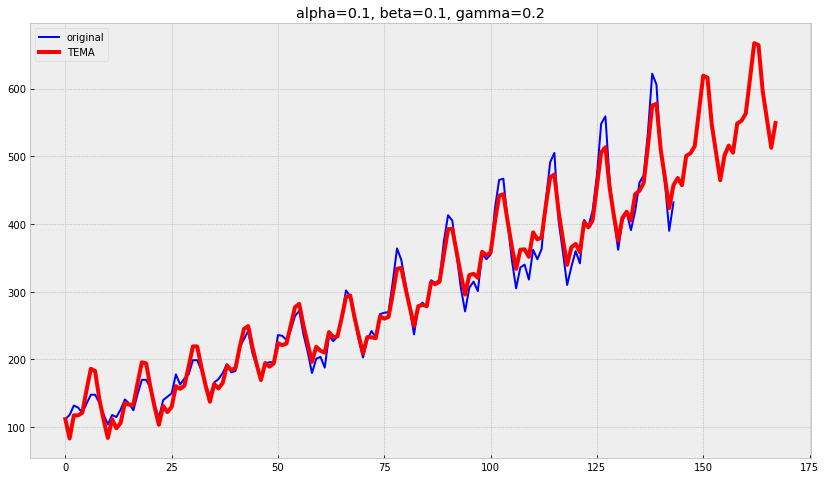

In [542]:
plot_tema(0.1, 0.1, 0.2)

In [543]:
train, val = series_airline[:65], series_airline[65:]

from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [ ]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
#print(opt)

plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series_airline, n_preds=len(val))